## GW detection

I downloaded data from [this file](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5), now let's classify this dataset

In [57]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [58]:
f = h5py.File('../astroML_data/sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')

In [59]:
list(f.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

In [60]:
snr_ds = np.array(f['snr'])
snr_ds

array([0.82250949, 1.09323729, 1.30539835, ..., 9.9752885 , 0.92040623,
       2.35090701])

In [61]:
threshold = 12   #snr treshold

In [62]:
det_ds = np.array(f['det'])
print(det_ds)

[0 0 0 ... 0 0 0]


### Separate sources that are detectable from those that aren't. 

We need to define a training set and a validation set of the snr and det

In [49]:
mask = snr_ds < 30 #i decided this threshold to eliminate spurious events
det = det_ds[mask]
snr = snr_ds[mask]

In [69]:
print(len(det_ds), len(det))

20000000 18669802


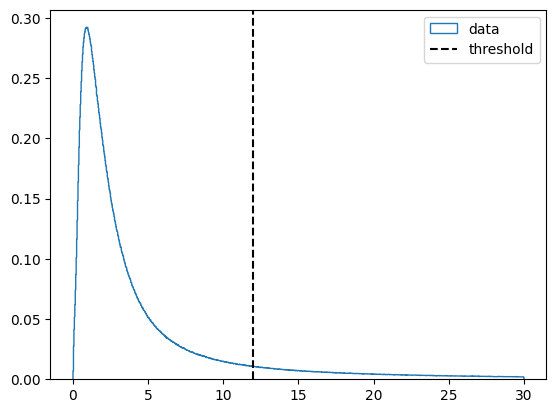

In [71]:
plt.hist(snr, bins = 1000, histtype = 'step', density=True, label ='data')
plt.axvline(12, 0,1, c='k', ls ='--', label = 'threshold')
plt.legend();

In [72]:
d = {}

for l in f.keys():
    d[l] = np.array(f[l])[mask]

In [11]:
print(d)

{'chi1x': array([-0.3072008 , -0.7347119 , -0.05783062, ..., -0.55825347,
        0.08477457, -0.03595039]), 'chi1y': array([ 0.27616489, -0.49849269, -0.70379617, ..., -0.10758872,
       -0.04276202,  0.02875862]), 'chi1z': array([-0.43075952, -0.29816229, -0.35451167, ...,  0.06524619,
        0.0177192 , -0.1645164 ]), 'chi2x': array([-0.1611142 ,  0.05753236, -0.21553765, ...,  0.3057056 ,
        0.14565681, -0.15248288]), 'chi2y': array([-0.09233378, -0.8449919 ,  0.01632286, ..., -0.21248981,
        0.47432107,  0.2724531 ]), 'chi2z': array([-0.41464697,  0.01470768,  0.13054284, ..., -0.41204831,
        0.74467675,  0.10790771]), 'dec': array([-0.32967056,  0.52673981,  0.3157986 , ..., -0.23687819,
        0.10406303, -0.02080332]), 'det': array([0, 0, 0, ..., 0, 0, 0]), 'iota': array([1.80931011, 0.82081964, 2.0082064 , ..., 0.89474102, 1.10206764,
       1.96556987]), 'mtot': array([906.80356183,  59.10211181,  44.60275026, ..., 536.49129182,
       879.05515228,  39.5713

The most important features are for sure the redshift and the masses, we can show this on a ROC curve

In [12]:
# remember to remove the SNR for your complete model! also det!!!
ll = list(f.keys())
print(ll)

['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']


In [13]:
ll.remove('snr')
ll.remove('det')
print(ll)

['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra', 'z']


In [14]:
X = np.array([d[l] for l in ll]).T
X = X[::100] #downsampling
print(X.shape) #all features

(186699, 13)


In [15]:
X_mz = np.array([d['z'], d['mtot'], d['q']]).T
X_mz = X_mz[::100] #downsampling
print(X_mz.shape) #only redshift and masses

(186699, 3)


In [16]:
y = d['det']
y = y[::100]
print(y)

[0 0 0 ... 1 0 0]


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train_mz, X_test_mz, y_train_mz, y_test_mz = train_test_split(X_mz, y, test_size=0.33, random_state=42)

In [18]:
X_train.shape

(125088, 13)

In [19]:
y_train.shape

(125088,)

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve

In [21]:
clf = GaussianNB()

clf.fit(X_train, y_train)

GaussianNB()

In [22]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test) [:,1] 

In [23]:
clf_mz = GaussianNB()

clf_mz.fit(X_train_mz, y_train_mz)

y_pred_mz = clf_mz.predict(X_test_mz)
y_prob_mz = clf_mz.predict_proba(X_test_mz) [:,1] 

In [24]:
fpr, tpr, thresh = roc_curve(y_test, y_prob)
fpr_mz, tpr_mz, thresh_mz = roc_curve(y_test_mz, y_prob_mz)

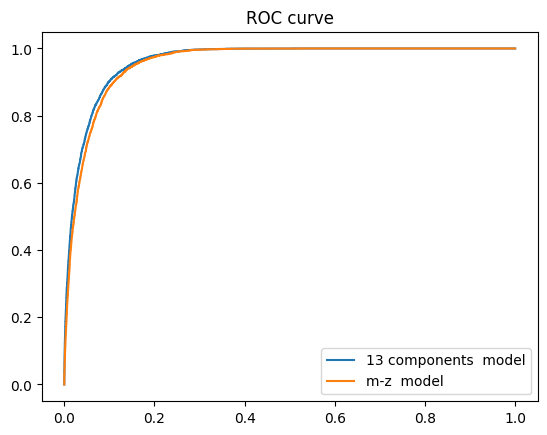

In [25]:
plt.plot(fpr, tpr, label='13 components  model')
plt.plot(fpr_mz, tpr_mz, label='m-z  model')
plt.legend()
plt.title('ROC curve');

In [26]:
from scipy.interpolate import interp1d
from scipy.integrate import quad
from warnings import filterwarnings

filterwarnings("ignore")

f_ = interp1d(fpr, tpr, 'linear')
xgrid = np.linspace(0,1,int(1e3))

print('%.4f' % quad(f_, a=0, b=1, limit=50)[0])

f_ = interp1d(fpr_mz, tpr_mz, 'linear')
print('%.4f' % quad(f_, a=0, b=1, limit=50)[0])

0.9628
0.9573


So essentially, all those other components account for about 1%, nonetheless our goal is to maximize the accuracy of our model, which is given by (true positive + true negative / total).

Let's calculate this for our two models

#### Validation on test dataset

In [27]:
import sklearn.metrics

C = sklearn.metrics.confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = C.ravel()

print('All 13 components')

print('completeness test: %.3f'  % (tp/(tp+fn)))
print('contamination test: %.3f' % (fp/(tp+fp)))

All 13 components
completeness test: 0.629
contamination test: 0.350


In [28]:
C_mz = sklearn.metrics.confusion_matrix(y_test_mz, y_pred_mz)

tn, fp, fn, tp = C_mz.ravel()

print('3 components')

print("completeness test: %.3f"  % (tp/(tp+fn)))
print("contamination test: %.3f" % (fp/(tp+fp)))

3 components
completeness test: 0.640
contamination test: 0.409


In [29]:
print('All 13 components')
print('Accuracy: %.3f' % np.sum(C.diagonal()/len(y_test)))
print()
print('3 components')
print('Accuracy: %.3f' % np.sum(C_mz.diagonal()/len(y_test)))

All 13 components
Accuracy: 0.942

3 components
Accuracy: 0.935


So the Naive Bayes algorithm is fast and easy but yields a very high contamination (contamination test). It is certainly not the best one.

### Trying other classifiers
By looking at the table in the lecture we expect Kernel Discriminant Analysis (KDA), which is a decision boundary algorithm, to work best. Let's try this out! From now on we will use the full 13 features

LDA kills kernel with 13 features, if i don't downsample

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf = LDA()

clf.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [31]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test) [:,1] 

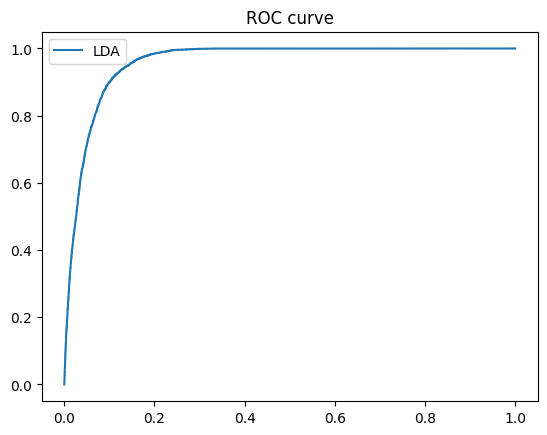

In [32]:
fpr, tpr, thresh = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label='LDA')
plt.legend()
plt.title('ROC curve');

In [33]:
from scipy.interpolate import interp1d
from scipy.integrate import quad
from warnings import filterwarnings

filterwarnings("ignore")

f_ = interp1d(fpr, tpr, 'linear')
xgrid = np.linspace(0,1,int(1e3))

print('%.4f' % quad(f_, a=0, b=1, limit=50)[0])

0.9586


#### Validation on test dataset

In [34]:
import sklearn.metrics

C = sklearn.metrics.confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = C.ravel()

print('LDA classifier')

print('completeness test: %.3f'  % (tp/(tp+fn)))
print('contamination test: %.3f' % (fp/(tp+fp)))

LDA classifier
completeness test: 0.048
contamination test: 0.237


In [35]:
print(C)

[[56544    75]
 [ 4751   241]]


odd result...

In [36]:
print('LDA')
print('Accuracy: %.3f' % np.sum(C.diagonal()/len(y_test)))

LDA
Accuracy: 0.922


### Is linearity the problem?
Maybe the boundary is not so well defined in the features space, let's try with a quadratic discrimination

In [73]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

clf = QDA()

clf.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [74]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test) [:,1] 

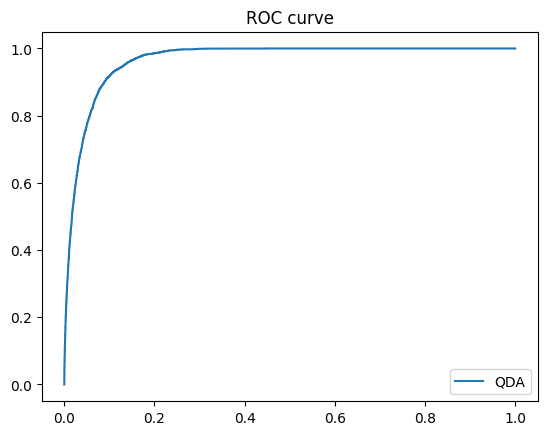

In [75]:
fpr, tpr, thresh = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label='QDA')
plt.legend()
plt.title('ROC curve');

In [76]:
from scipy.interpolate import interp1d
from scipy.integrate import quad
from warnings import filterwarnings

filterwarnings("ignore")

f_ = interp1d(fpr, tpr, 'linear')
xgrid = np.linspace(0,1,int(1e3))

print('%.4f' % quad(f_, a=0, b=1, limit=50)[0])

0.9657


#### Validation on test dataset

In [78]:
import sklearn.metrics

C = sklearn.metrics.confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = C.ravel()

print('QDA classifier')

print('completeness test: %.3f'  % (tp/(tp+fn)))
print('contamination test: %.3f' % (fp/(tp+fp)))

QDA classifier
completeness test: 0.689
contamination test: 0.372


In [79]:
print(C)

[[54583  2036]
 [ 1554  3438]]


better but still not perfect

In [80]:
print('QDA')
print('Accuracy: %.3f' % np.sum(C.diagonal()/len(y_test)))

QDA
Accuracy: 0.942


### Let's try GMMBayes, last time it worked pretty well
This is a density estimation scheme based on gaussian mixtures

In [37]:
from astroML.classification import GMMBayes

clf = GMMBayes(n_components=4)

clf.fit(X_train, y_train)

GMMBayes(n_components=array([4]))

In [38]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test) [:,1] 

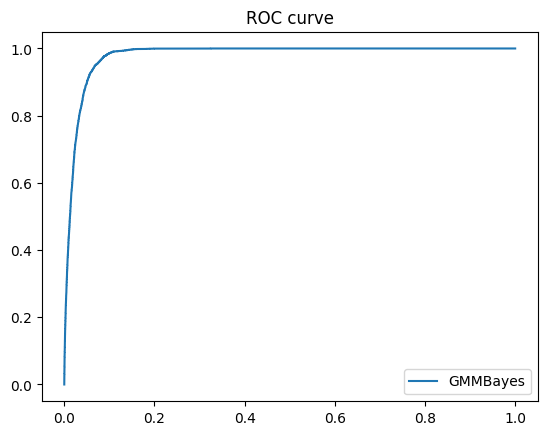

In [39]:
fpr, tpr, thresh = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label='GMMBayes')
plt.legend()
plt.title('ROC curve');

In [40]:
from scipy.interpolate import interp1d
from scipy.integrate import quad
from warnings import filterwarnings

filterwarnings("ignore")

f_ = interp1d(fpr, tpr, 'linear')
xgrid = np.linspace(0,1,int(1e3))

print('%.4f' % quad(f_, a=0, b=1, limit=50)[0])

0.9794


#### Validation on test dataset

In [41]:
import sklearn.metrics

C = sklearn.metrics.confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = C.ravel()

print('GMM classifier')

print('completeness test: %.3f'  % (tp/(tp+fn)))
print('contamination test: %.3f' % (fp/(tp+fp)))

GMM classifier
completeness test: 0.778
contamination test: 0.309


In [42]:
print(C)

[[54882  1737]
 [ 1108  3884]]


In [43]:
print('GMMBayes')
print('Accuracy: %.3f' % np.sum(C.diagonal()/len(y_test)))

GMMBayes
Accuracy: 0.954
